## Import driver

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip images and mask dataset

In [2]:
!unzip /content/drive/MyDrive/FilteredMasks.zip -d FilteredMasks

Archive:  /content/drive/MyDrive/FilteredMasks.zip
  inflating: FilteredMasks/2009_001816.png  
  inflating: FilteredMasks/2007_006866.png  
  inflating: FilteredMasks/2008_001159.png  
  inflating: FilteredMasks/2008_000361.png  
  inflating: FilteredMasks/2009_001851.png  
  inflating: FilteredMasks/2010_000195.png  
  inflating: FilteredMasks/2010_002536.png  
  inflating: FilteredMasks/2009_004969.png  
  inflating: FilteredMasks/2007_002914.png  
  inflating: FilteredMasks/2007_004052.png  
  inflating: FilteredMasks/2007_000333.png  
  inflating: FilteredMasks/2008_000074.png  
  inflating: FilteredMasks/2008_000589.png  
  inflating: FilteredMasks/2008_001260.png  
  inflating: FilteredMasks/2011_001135.png  
  inflating: FilteredMasks/2007_003587.png  
  inflating: FilteredMasks/2010_003514.png  
  inflating: FilteredMasks/2010_005531.png  
  inflating: FilteredMasks/2010_002691.png  
  inflating: FilteredMasks/2007_001609.png  
  inflating: FilteredMasks/2010_002139.png  
  in

In [3]:
!unzip /content/drive/MyDrive/FilteredImages.zip -d FilteredImages

Archive:  /content/drive/MyDrive/FilteredImages.zip
  inflating: FilteredImages/2007_004663.jpg  
  inflating: FilteredImages/2010_006054.jpg  
  inflating: FilteredImages/2011_000149.jpg  
  inflating: FilteredImages/2011_001922.jpg  
  inflating: FilteredImages/2008_000630.jpg  
  inflating: FilteredImages/2010_003771.jpg  
  inflating: FilteredImages/2009_000446.jpg  
  inflating: FilteredImages/2011_001855.jpg  
  inflating: FilteredImages/2008_003986.jpg  
  inflating: FilteredImages/2009_003810.jpg  
  inflating: FilteredImages/2007_007878.jpg  
  inflating: FilteredImages/2009_002988.jpg  
  inflating: FilteredImages/2010_000572.jpg  
  inflating: FilteredImages/2011_001866.jpg  
  inflating: FilteredImages/2009_002204.jpg  
  inflating: FilteredImages/2009_002571.jpg  
  inflating: FilteredImages/2008_003270.jpg  
  inflating: FilteredImages/2007_003205.jpg  
  inflating: FilteredImages/2009_002887.jpg  
  inflating: FilteredImages/2007_005469.jpg  
  inflating: FilteredImages/

In [ ]:
!pip install tensorflow numpy matplotlib opencv-python

In [4]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

## Load dataset

In [5]:
# Define paths
images_dir = 'FilteredImages/'
masks_dir = 'FilteredMasks/'
num_classes = 21  # Number of classes in Pascal VOC
target_size = (256, 256)  # Resize images and masks to this size

# load and preprocess images and masks
def load_data(images_dir, masks_dir, target_size=(256, 256)):
    images = []
    masks = []
    missing_count = 0
    image_filenames = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    for img_name in image_filenames:
        img_path = os.path.join(images_dir, img_name)
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(masks_dir, mask_name)

        if not os.path.exists(mask_path):
            missing_count += 1
            print(f"Mask not found for image: {img_name}")
            continue

        # Load image and mask
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            missing_count += 1
            print(f"Could not load image or mask for: {img_name}")
            continue

        # Resize images and masks
        img = cv2.resize(img, target_size)
        mask = cv2.resize(mask, target_size)

        # Check unique mask values
        unique_values = np.unique(mask)
        # print(f"Unique values in mask {mask_name}: {unique_values}")

        if np.max(unique_values) >= num_classes:
            # print(f"Warning: Mask values exceed number of classes for {mask_name}. Trimming to fit range [0, {num_classes-1}].")
            mask = np.clip(mask, 0, num_classes-1)

        # Normalize images and convert masks to categorical
        img = img / 255.0
        mask = to_categorical(mask, num_classes=num_classes)

        images.append(img)
        masks.append(mask)

    print("missing_count: ", missing_count)

    return np.array(images), np.array(masks)

# Load data
X, Y = load_data(images_dir, masks_dir)

missing_count:  0


# Define U-Net Model

In [6]:
# Define U-Net model
def unet(input_shape=(256, 256, 3), num_classes=21):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Instantiate the model
model = unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Train model with 6 epoch and test it after every epoch

In [7]:
# Define the path to save checkpoints
checkpoint_path = '/content/drive/MyDrive/UNET/unet_epoch_{epoch:02d}.h5'

# Define model checkpoint
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True)

# Function to visualize predictions
def visualize_predictions(model, X, Y, epoch):
    sample_indices = np.random.choice(len(X), 3)
    for i, idx in enumerate(sample_indices):
        img = X[idx]
        mask = Y[idx]
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        pred = np.argmax(pred, axis=-1)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(img)

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth')
        plt.imshow(np.argmax(mask, axis=-1))

        plt.subplot(1, 3, 3)
        plt.title(f'Prediction (Epoch {epoch})')
        plt.imshow(pred)
        plt.show()

1/1 [==============================] - 0s 367ms/step


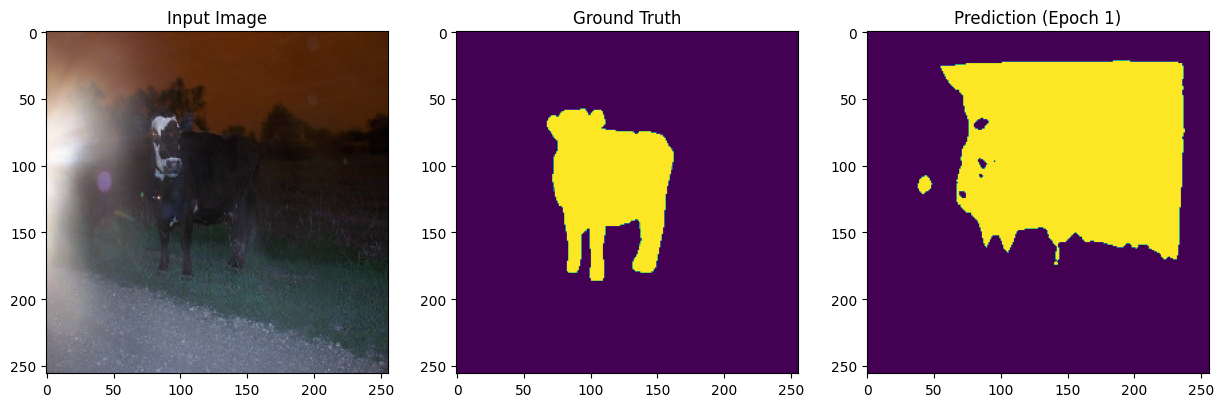

1/1 [==============================] - 0s 144ms/step


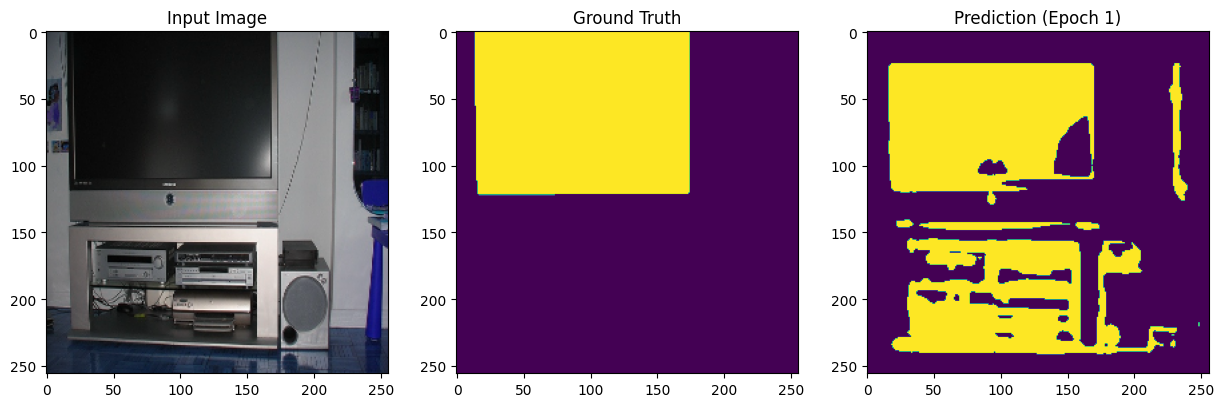

1/1 [==============================] - 0s 166ms/step


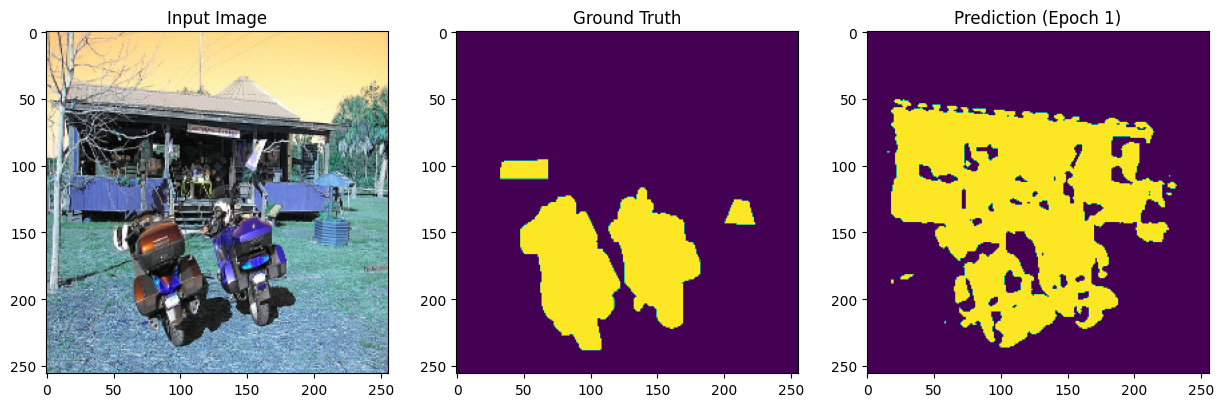

1/1 [==============================] - 0s 168ms/step


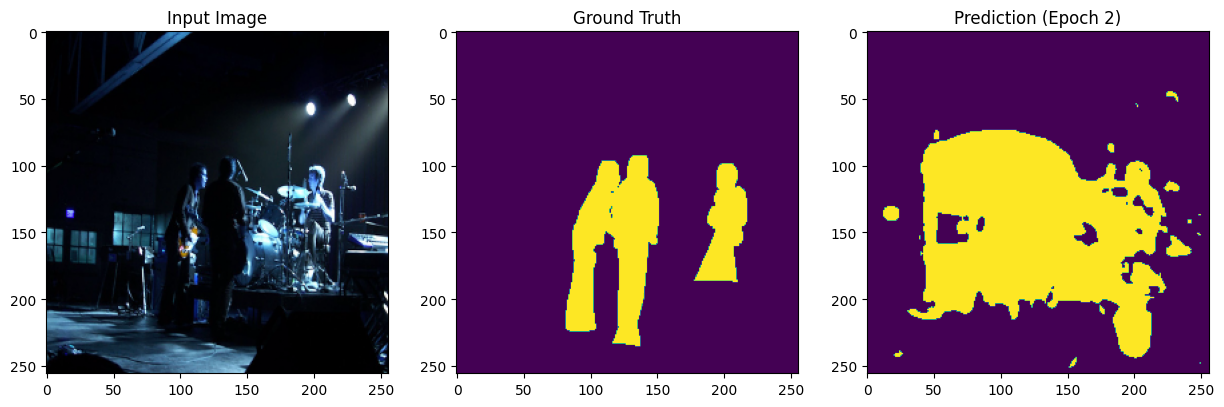

1/1 [==============================] - 0s 166ms/step


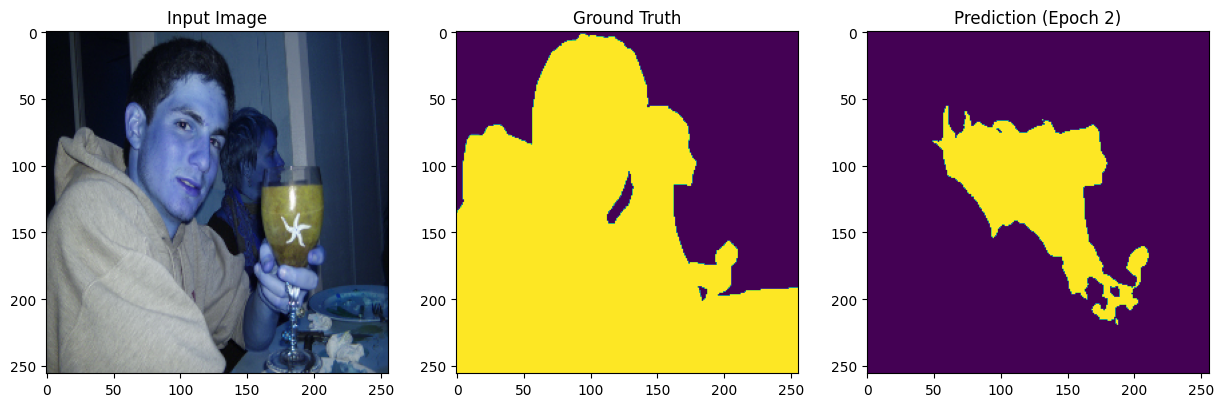

1/1 [==============================] - 0s 165ms/step


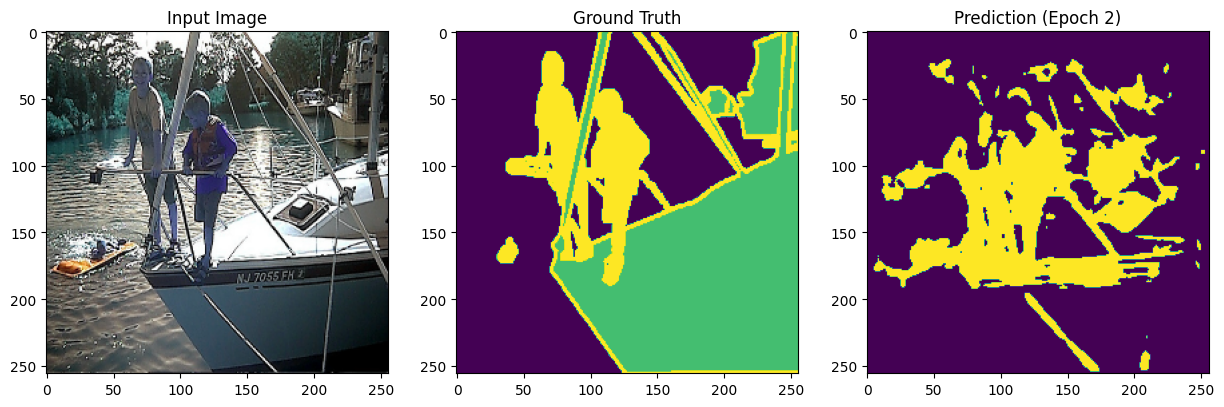

1/1 [==============================] - 0s 166ms/step


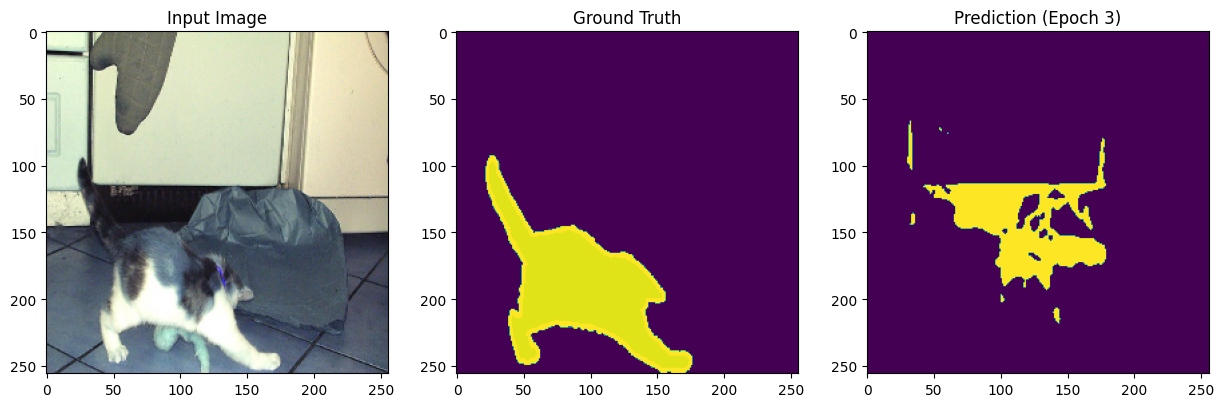

1/1 [==============================] - 0s 165ms/step


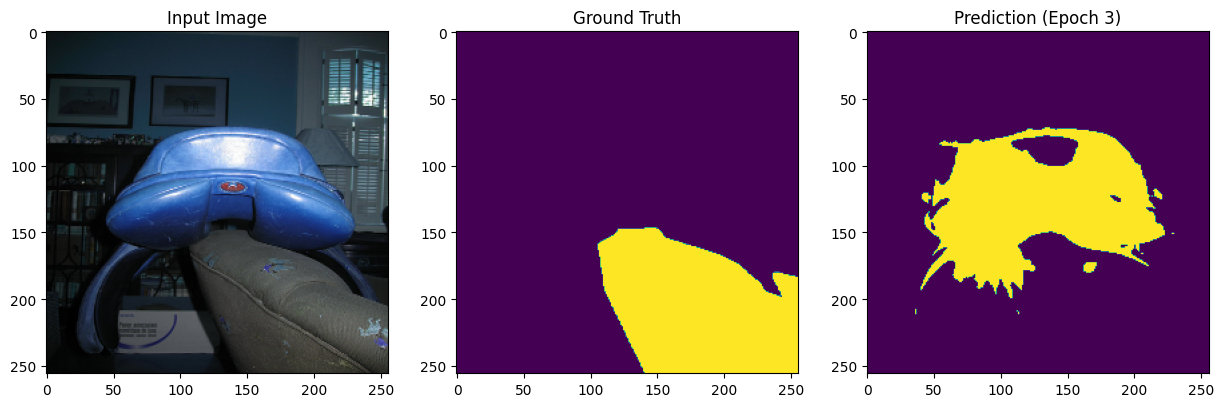

1/1 [==============================] - 0s 165ms/step


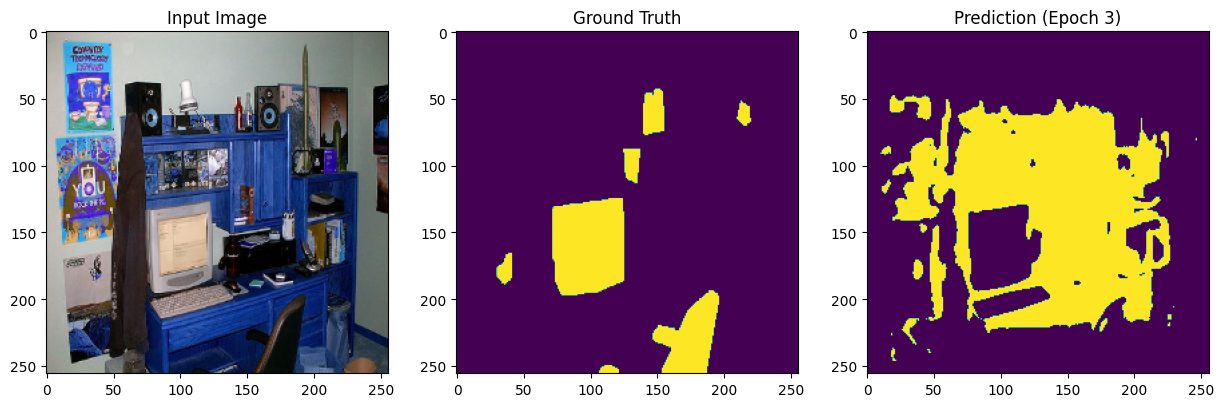

1/1 [==============================] - 0s 166ms/step


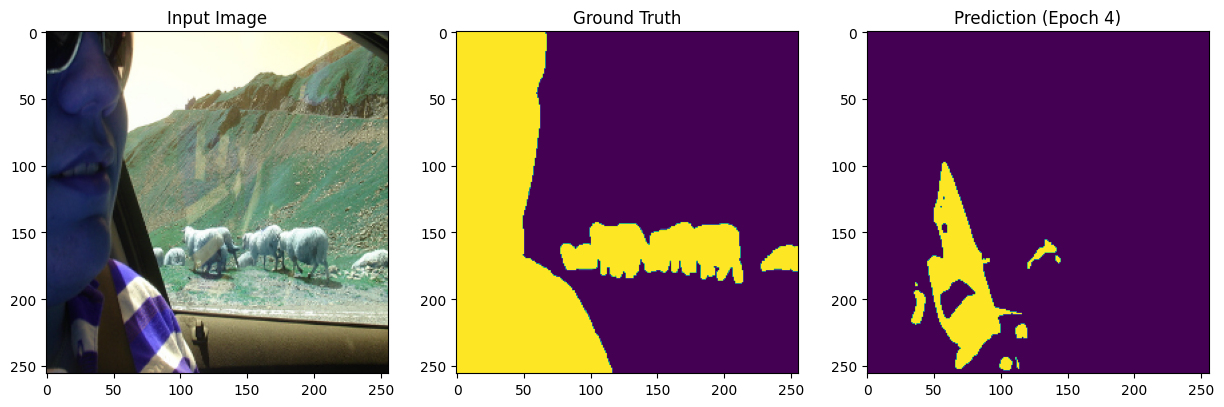

1/1 [==============================] - 0s 162ms/step


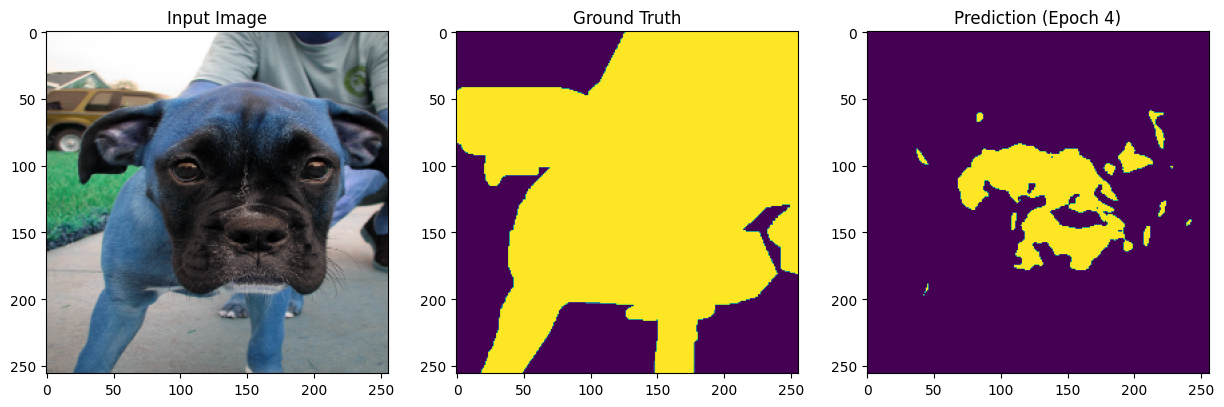

1/1 [==============================] - 0s 167ms/step


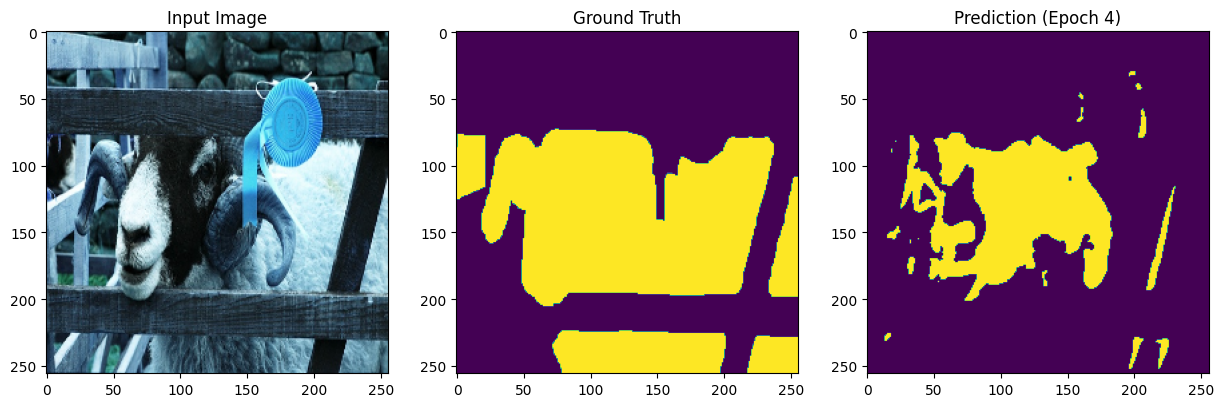

1/1 [==============================] - 0s 179ms/step


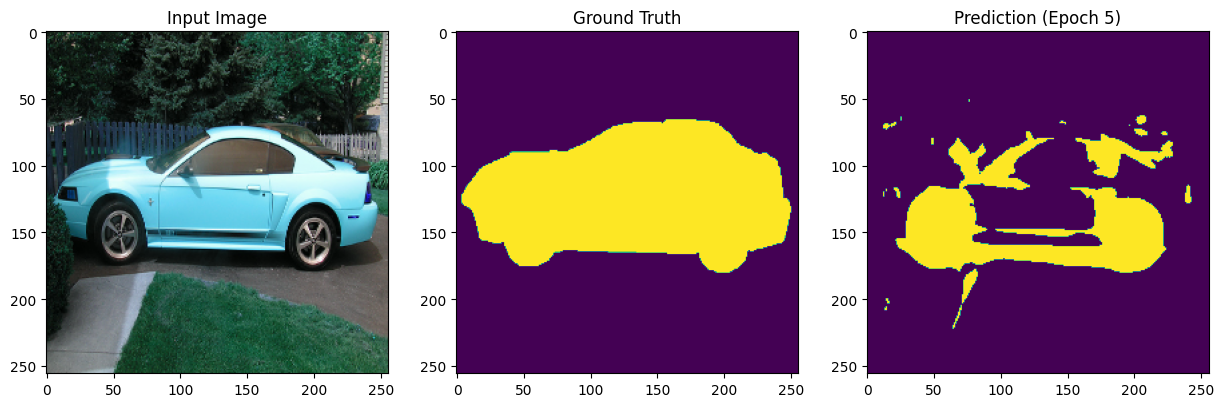

1/1 [==============================] - 0s 169ms/step


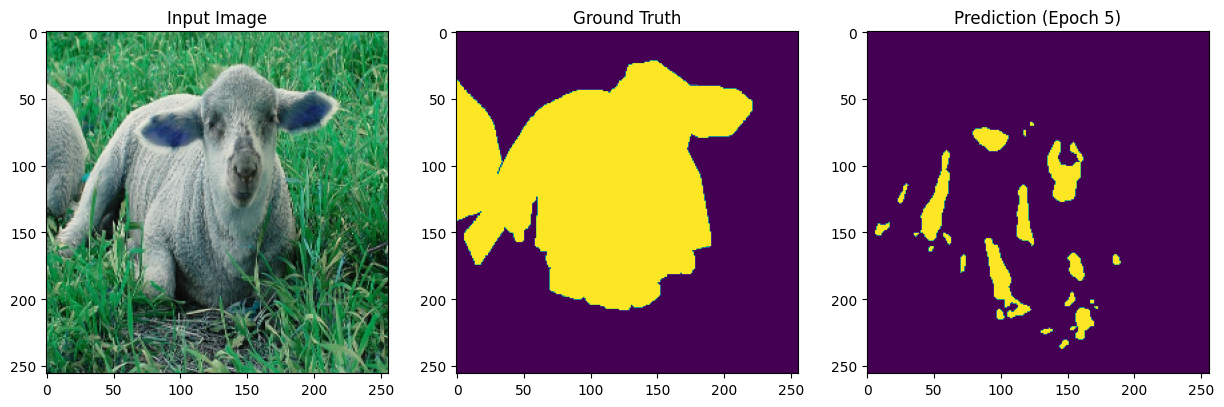

1/1 [==============================] - 0s 167ms/step


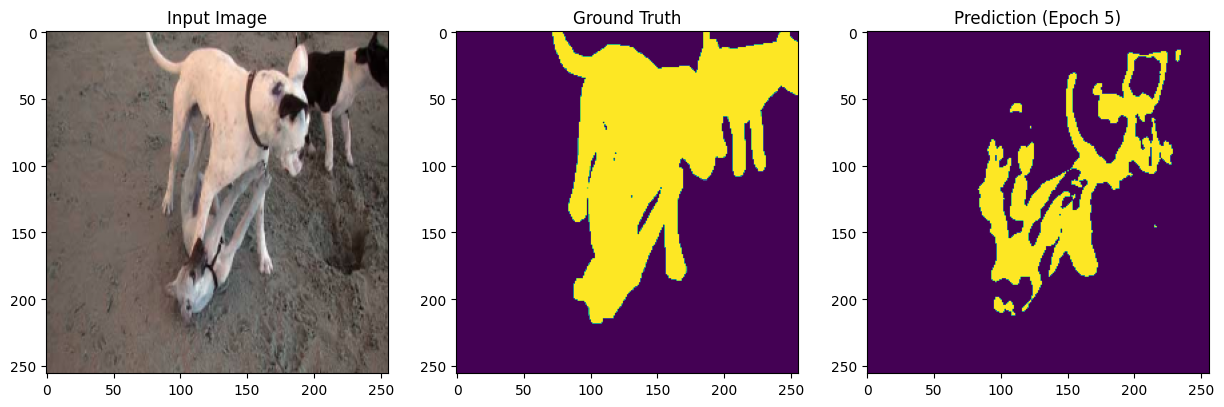

1/1 [==============================] - 0s 168ms/step


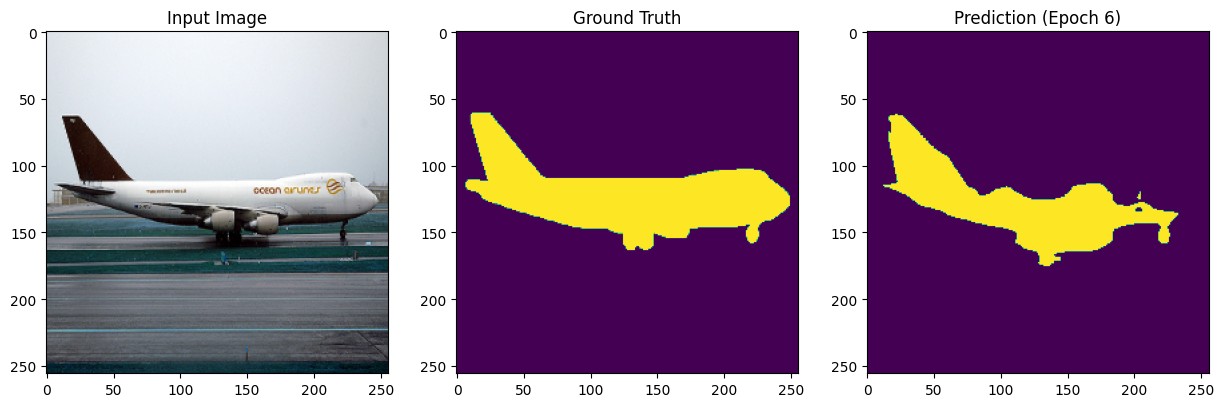

1/1 [==============================] - 0s 160ms/step


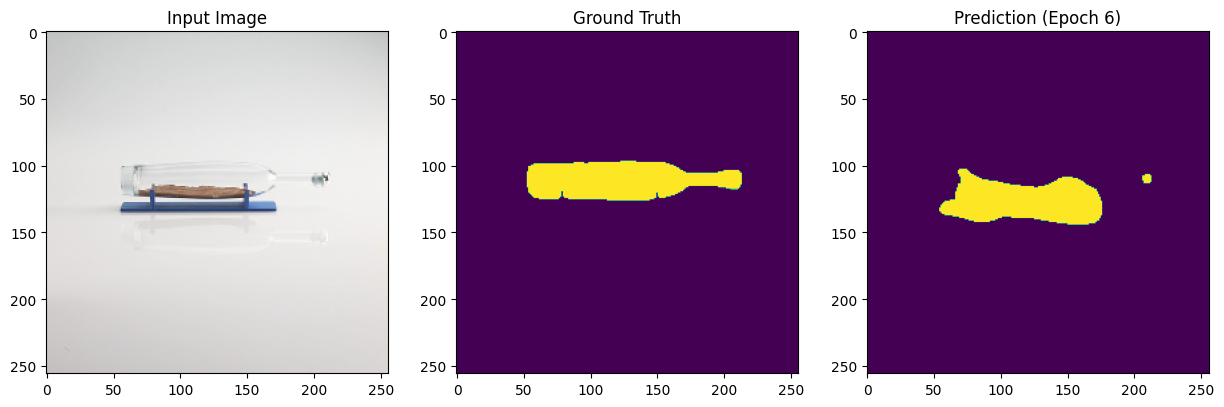

1/1 [==============================] - 0s 166ms/step


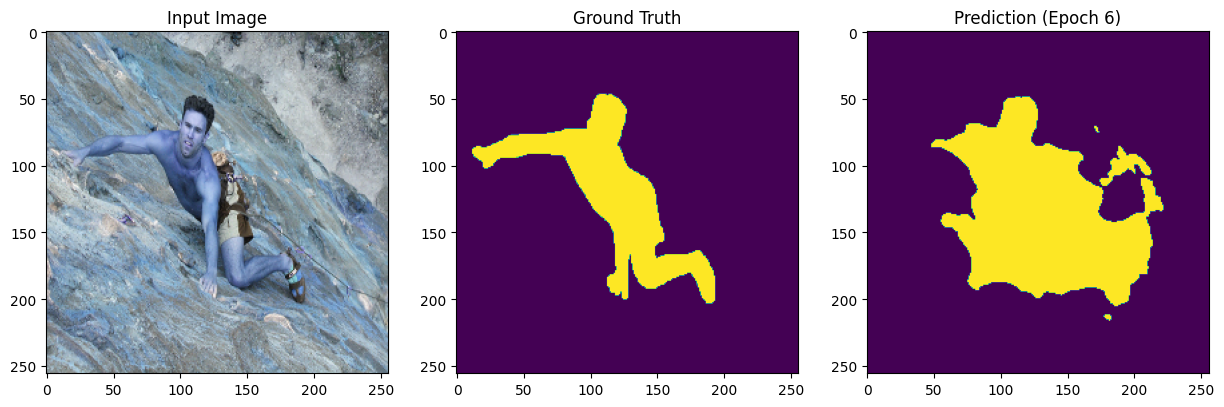

In [ ]:
# Train the model
epochs = 6
batch_size = 8

for epoch in range(epochs):
    model.fit(X, Y, epochs=1, batch_size=batch_size, callbacks=[checkpoint])
    visualize_predictions(model, X, Y, epoch+1)

## Train model 7th epoch and test it after epoch

1/1 [==============================] - 0s 166ms/step


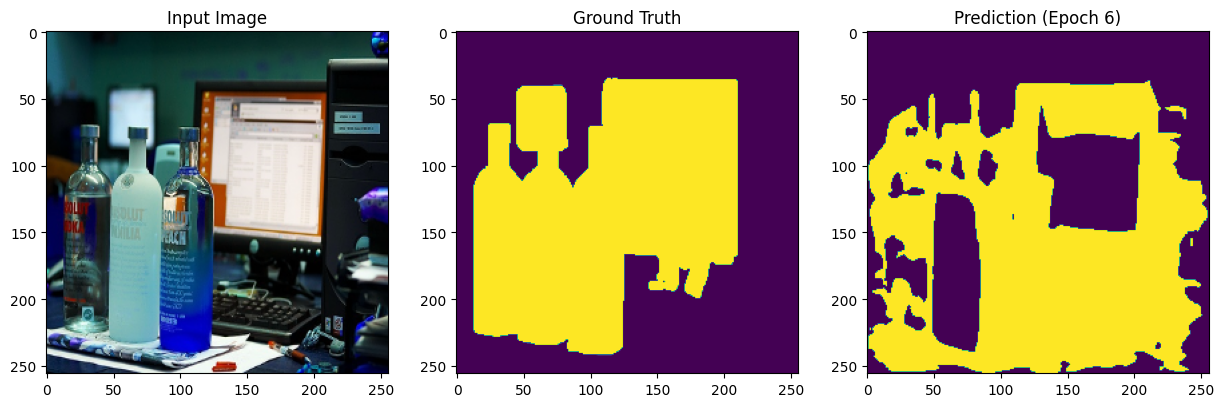

1/1 [==============================] - 0s 167ms/step


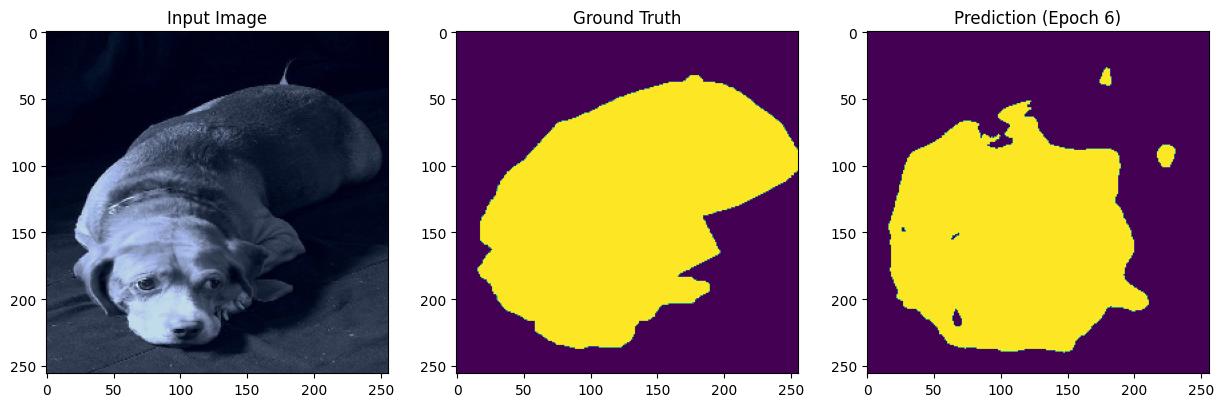

1/1 [==============================] - 0s 140ms/step


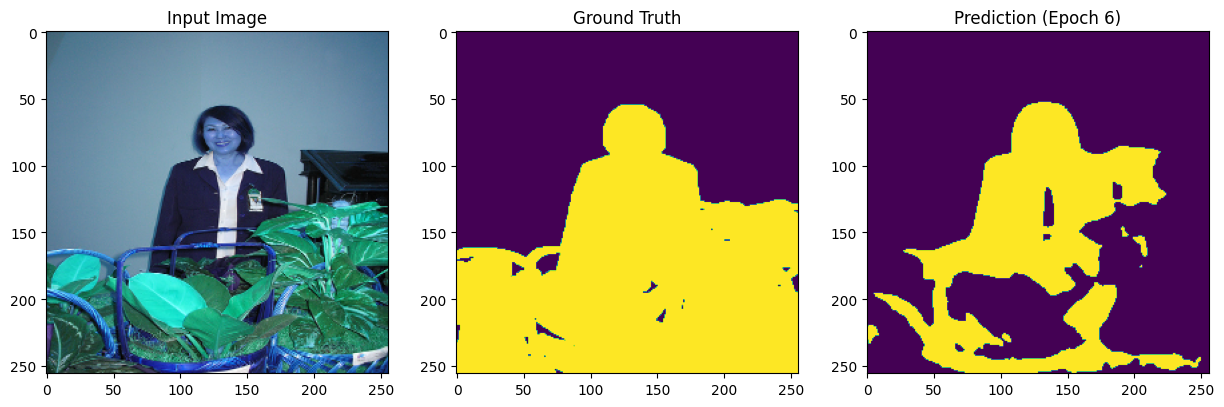

In [ ]:
model.fit(X, Y, epochs=1, batch_size=batch_size, callbacks=[checkpoint])
visualize_predictions(model, X, Y, epoch+1)

## save the model in google drive

In [ ]:
model.save('/content/drive/MyDrive/unet_epoch_final2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## you can access to the model with below urls

unet_epoch_final2.h5: [Link](https://drive.google.com/file/d/1--bmIg-H9v3ap9RzUEL4jNp5P2AwrM17/view?usp=drive_link)

## check mean IoU metric

In [8]:
# Load the pre-trained model
model = unet()
model.load_weights('/content/drive/MyDrive/unet_epoch_final2.h5')

# Function to calculate Mean IoU
def mean_iou(y_true, y_pred, threshold=0.5):
    y_pred_th = (y_pred > threshold).astype(int)
    y_true = np.argmax(y_true, axis=-1)  # Convert categorical to label index
    y_pred_th = np.argmax(y_pred_th, axis=-1)

    intersection = np.logical_and(y_true, y_pred_th)
    union = np.logical_or(y_true, y_pred_th)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [9]:
# Predict on the dataset
y_pred = model.predict(X)

# Calculate Mean IoU
iou = mean_iou(Y, y_pred)
print(f'Mean IoU: {iou}')

92/92 [==============================] - 213s 2s/step
Mean IoU: 0.4745346580849613
